# Project 5: 
# Expedia Hotel Recommendations
## Which hotel type will an Expedia customer book?

## Table of Contents:

### Part 1
1. [Background](#1.-Background)  
1. [Problem Statement](#2.-Problem-Statement)  
1. [Executive Summary](#3.-Executive-Summary)  
1. [Exploratory Data Analysis and Data Cleaning](#4.-Exploratory-Data-Analysis-and-Data-Cleaning)  
    1. [Data Dictionary](#a.-Data-Dictionary)  
    1. [Preliminary Data Cleaning](#b.-Preliminary-Data-Cleaning) 
    1. [Preliminary Exploratory Data Analysis](#c.-Preliminary-Exploratory-Data-Analysis) 
    1. [Feature Engineering](#d.-Feature-Engineering) 
    1. [More Exploratory Data Analysis](#e.-More-Exploratory-Data-Analysis) 
    1. [Final Data Cleaning and processing the whole dataset](#f.-Final-Data-Cleaning-and-processing-the-whole-dataset) 
    

### Part 2
5. [Final Dataset Preparation for Modelling](#5.-Final-Dataset-Preparation-for-Modelling)
1. [Modeling](#6.-Modeling)    
    1. [Preprocessing Functions](#a.-Preprocessing-Functions)
    1. [Base Case](#b.-Base-Case)
    1. [Categorical Naive Bayes](#c.-Categorical-Naive-Bayes)
    1. [Random Forrest Classifier Model](#d.-Random-Forrest-Classifier-Model)
    1. [K Nearest Neighbor](#e.-K-Nearest-Neighbor)
1. [TensorFlow Recommedation System](#7.-TensorFlow-Recommendation-System)
1. [Conclusion and Recommendations](#8.-Conclusion-and-Recommendations)  
1. [References and Data Sources](#9.-References-and-Data-Sources) 

### Appendix
1. [TensorFlow Recommedation System]()

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import f1_score, average_precision_score
import ml_metrics as metrics

from datetime import timedelta

#### Functions to convert format of predicted results

In [2]:
# convert format from ml_metrics format to kaggle submission format

def convert_mapkformat_to_kaggleformat(kaggle_pred, kaggle):
    # to convert file format for ml_metrics mapk@5 to kaggle submission format

    def convert_to_string(list):
        #to convert list to string
        list_string = [str(x) for x in list]
        return ' '.join(list_string)
    
    submit['id'] = kaggle[['id']].copy(deep = True)
    submit['hotel_cluster'] = kaggle_pred
    submit['hotel_cluster'] = submit['hotel_cluster'].map(lambda x: convert_to_string(x))

    return submit

In [3]:
def convert_pdformat_to_kaggleformat(kaggle_pred, kaggle):
    
    submit = kaggle[['id']].copy(deep = True)
    submit['hotel_cluster']= kaggle_pred.apply(lambda x: ' '.join(kaggle_pred.columns[np.array(x).argsort()[::-1][:5]].astype(str).to_list()), axis=1)
    
    return submit

## 5. Final Dataset Preparation for Modelling

#### Loading in the Data

In [4]:
data = pd.read_csv('../datasets/train_clean.csv')
kaggle = pd.read_csv('../datasets/test_clean.csv')

In [5]:
data.head(2)

,date_time,user_location_city,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,cnt,hotel_market,hotel_cluster,days_to_checkin,stay_length,month_of_booking,month_of_staying
0,2014-08-11,48862,12,0,1,9,2,0,1,8250,1,628,1,18,4,8,8
1,2014-02-27,52078,756,0,1,4,2,0,1,8291,1,191,2,50,2,2,4


In [6]:
kaggle.head(2)

,id,date_time,user_location_city,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,hotel_market,days_to_checkin,stay_length,month_of_booking,month_of_staying
0,0,2015-09-03,37449,1,1,0,3,2,0,1,12243,27,259.0,4.0,9,5.0
1,1,2015-09-24,37449,1,1,0,10,2,0,1,14474,1540,231.0,3.0,9,5.0


In [7]:
data.nunique()

date_time                 726
user_location_city      36917
user_id                813985
is_mobile                   2
is_package                  2
channel                    11
srch_adults_cnt            10
srch_children_cnt          10
srch_rm_cnt                 9
srch_destination_id     36933
cnt                        16
hotel_market             2103
hotel_cluster             100
days_to_checkin           497
stay_length                35
month_of_booking           12
month_of_staying           12
dtype: int64

In [8]:
kaggle.nunique()

id                     2528243
date_time                  360
user_location_city       36722
user_id                1181577
is_mobile                    2
is_package                   2
channel                     11
srch_adults_cnt             10
srch_children_cnt           10
srch_rm_cnt                  9
srch_destination_id      40718
hotel_market              2115
days_to_checkin            504
stay_length                223
month_of_booking            12
month_of_staying            12
dtype: int64

In [9]:
data.dtypes

date_time              object
user_location_city      int64
user_id                 int64
is_mobile               int64
is_package              int64
channel                 int64
srch_adults_cnt         int64
srch_children_cnt       int64
srch_rm_cnt             int64
srch_destination_id     int64
cnt                     int64
hotel_market            int64
hotel_cluster           int64
days_to_checkin         int64
stay_length             int64
month_of_booking        int64
month_of_staying        int64
dtype: object

In [10]:
kaggle.dtypes

id                       int64
date_time               object
user_location_city       int64
user_id                  int64
is_mobile                int64
is_package               int64
channel                  int64
srch_adults_cnt          int64
srch_children_cnt        int64
srch_rm_cnt              int64
srch_destination_id      int64
hotel_market             int64
days_to_checkin        float64
stay_length            float64
month_of_booking         int64
month_of_staying       float64
dtype: object

In [11]:
# making sure the data and kaggle set have the same dtypes
kaggle['days_to_checkin'] = kaggle['days_to_checkin'].astype('int64')
kaggle['stay_length'] = kaggle['stay_length'].astype('int64')
kaggle['month_of_staying'] = kaggle['month_of_staying'].astype('int64')

In [12]:
kaggle.dtypes

id                      int64
date_time              object
user_location_city      int64
user_id                 int64
is_mobile               int64
is_package              int64
channel                 int64
srch_adults_cnt         int64
srch_children_cnt       int64
srch_rm_cnt             int64
srch_destination_id     int64
hotel_market            int64
days_to_checkin         int64
stay_length             int64
month_of_booking        int64
month_of_staying        int64
dtype: object

## 6. Modeling

As mentioned in the EDA section, since our features are all nominal features, there is no linearity between them. As such, the machine learning models that we can deploy is limited. Logistic Regression and K-Nearest Neighbors might not work well as they needed to be able to transform within the features some intra linear relationship like distance between points etc. As such we try are going to try models that do not make this assumption like Decision Tree, Random Forest and Naive Bayes.

### a. Preprocessing Functions

In [13]:
# initial preprocessing

def preprocessing(df):
    
    #change to only year
    df['date_time'] = pd.to_datetime(df['date_time'], format = '%Y-%m-%d').dt.year 
    
    # if number of adult is 0, normally it means 1:
    df['srch_adults_cnt'] = df['srch_adults_cnt'].map(lambda x: 1 if x == 0 else x)
    
    # if number of room is 0, normally it means 1:
    df['srch_rm_cnt'] = df['srch_rm_cnt'].map(lambda x: 1 if x == 0 else x)

    #categorise to 1 for short stay (1 day), 2 for normal stay (2 days to a week) and 3 for long stay (more than a week)
    df['stay_length'] = df['stay_length'].map(lambda x: 1 if x<=1 else(2 if x in range(2, 8) else 3))
    
    #categorise to 1 for urgent booking (1 day), 2 for normal booking (2 days to a month in advance) and 3 for advance booking (more than a month prior)
    df['days_to_checkin']= df['days_to_checkin'].map(lambda x: 1 if x<=1 else(2 if x in range(2, 30) else 3))
    
    return df

data = preprocessing(data)
kaggle = preprocessing(kaggle)

In [14]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    
    # Encoder to solve issue where train set might not have categories that exist in test set
    # Seek to group these 'missing' categories under category 0
    
    def __init__(self):
        self.freq = {}
        
    def fit(self, X, y = None):
        
        for column in X.columns:
        
            #get frequency of each category in feature
            self.freq[column] = X[column].value_counts(normalize = True)
            
        return self
            
    def transform(self, X, y = None):
        X_ = X.copy(deep = True)
        
        for column in X.columns:

            mapping = X_[column].map(self.freq[column])
            
            #Map to category 'others' if category in testset do not appear in trainset
#             X_[column] = X_[column].map(lambda x: x if self.freq[column].get(x, False) else '0')
            X_[column] = X_[column].map(lambda x: x if self.freq[column].get(x, False) else 'others')
            
            #Map to category 'others' if category belongs to 10% of the smallest occurance
            #             X_[column] = X_[column].mask(mapping <= self.freq[column].quantile(q=0.1), '0')
            X_[column] = X_[column].mask(mapping <= self.freq[column].quantile(q=0.1), 'others')
        
        X_ = X_.astype(str)

        return X_

### b. Base Case

In [15]:
X = data.drop(['date_time','cnt','hotel_cluster'], axis = 1)
y = data['hotel_cluster']
X_train, X_hold, y_train, y_hold = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                    stratify=y                                                    
                                                   )

In [16]:
y_hold.value_counts(normalize = True)

91    0.040315
48    0.028452
42    0.024369
59    0.022198
28    0.021322
        ...   
92    0.002144
87    0.002108
53    0.001708
27    0.000894
74    0.000821
Name: hotel_cluster, Length: 100, dtype: float64

In [17]:
pred = y_hold.value_counts()[0:5].index
pred = list(pred)
pred

[91, 48, 42, 59, 28]

In [18]:
predictions = [pred for _ in range(len(y_train))]
target = [[x] for x in y_train.values]
print(f'Trainset Map@5 score: {metrics.mapk(target, predictions, k=5)}')

Trainset Map@5 score: 0.0724775114836474


In [19]:
predictions = [pred for _ in range(len(y_hold))]
target = [[x] for x in y_hold.values]
print(f'Testset Map@5 score: {metrics.mapk(target, predictions, k=5)}')

Testset Map@5 score: 0.07247740746369064


Here we establish the baseline score of 0.0725 whereby make the predicting as the top 5 most popular hotel clusters.

#### Predict for Kaggle (Only Run if Wanted to save file for Kaggle Submission)

In [20]:
# kaggle_pred = [pred for _ in range(len(kaggle))]
# submit = convert_mapkformat_to_kaggleformat(kaggle_pred, kaggle)
# submit.to_csv('../datasets/submission_baseline.csv', index = False)

The Kaggle Score for this baseline model is also 0.07

### c. Categorical Naive Bayes

#### Smaller Dataset (10 categories)

In [21]:
#subset if needed

most_popular_hotel_clusters = list(data['hotel_cluster'].value_counts()[0:10].index)
data_sub = data[data['hotel_cluster'].map(lambda x: x in most_popular_hotel_clusters)]
data_sub = data_sub[:100_000]

X = data_sub.drop(['date_time','cnt','hotel_cluster'], axis = 1)
y = data_sub['hotel_cluster']
X_train, X_hold, y_train, y_hold = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                    stratify=y                                                
                                                   )

In [22]:
len(X)

100000

In [23]:
y.value_counts()

91    17688
48    12721
42    10676
59     9660
28     9282
16     8225
18     8068
50     7947
95     7943
82     7790
Name: hotel_cluster, dtype: int64

In [24]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import SMOTEN

pipe = make_pipeline(CategoricalEncoder(),   
                     OrdinalEncoder(),                     
                     CategoricalNB())

params = {'categoricalnb__alpha': [1, 1.2]}

gs = GridSearchCV(pipe,
                  param_grid= params,
                  cv = 5,
                  scoring = 'f1_weighted',
                  n_jobs = -1,
                  error_score='raise',
                 )

In [25]:
# model have been ran and saved.

# gs.fit(X_train,y_train)
# print(f'Best Grid Search Score: {gs.best_score_}')
# print(f'Best Params: {gs.best_params_}')
# model = gs.best_estimator_

# pickle.dump(model, open('../models/CategoricalNB_10_classes_NoSMOTE.sav', 'wb'))

Best Grid Search Score: 0.4077309964998639
Best Params: {'categoricalnb__alpha': 1}


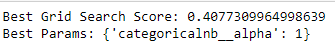

In [26]:
model = pickle.load(open('../models/CategoricalNB_10_classes_NoSMOTE.sav', 'rb'))

print(f'Train Score: {model.score(X_train, y_train)}')
print(f'Holdout Score: {model.score(X_hold,y_hold)}')
print(f"Train F1 score: {f1_score(y_train, model.predict(X_train), average = 'weighted')}")
print(f"Holdout F1 score: {f1_score(y_hold, model.predict(X_hold), average = 'weighted')}")

Train Score: 0.5878133333333333
Holdout Score: 0.42436
Train F1 score: 0.5824220638651971
Holdout F1 score: 0.41179066113123064


In [27]:
def mapk_score(model, X, y):
    predictions = model.predict_proba(X)
    predictions = pd.DataFrame(predictions, columns = model.classes_)
    predictions = [predictions.loc[x].sort_values(ascending = False)[0:5].index.values.tolist() for x in range(len(y))]
    target = [[x] for x in y.values]
    return metrics.mapk(target, predictions, k=5)

In [28]:
print(f'Trainset MAP@5 score: {mapk_score(model, X_train, y_train)}')
print(f'Testset MAP@5 score: {mapk_score(model, X_hold, y_hold)}')

Trainset MAP@5 score: 0.7354015555555555
Testset MAP@5 score: 0.603636


#### Smaller Dataset (10 categories) (with SMOTE)

In [29]:
#subset if needed

most_popular_hotel_clusters = list(data['hotel_cluster'].value_counts()[0:10].index)
data_sub = data[data['hotel_cluster'].map(lambda x: x in most_popular_hotel_clusters)]
data_sub = data_sub[:100000]

X = data_sub.drop(['date_time','cnt','hotel_cluster'], axis = 1)
y = data_sub['hotel_cluster']
X_train, X_hold, y_train, y_hold = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                    stratify=y                                                
                                                   )

In [30]:
len(X)

100000

In [31]:
y.value_counts()

91    17688
48    12721
42    10676
59     9660
28     9282
16     8225
18     8068
50     7947
95     7943
82     7790
Name: hotel_cluster, dtype: int64

In [32]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import SMOTEN

pipe = imb_make_pipeline(CategoricalEncoder(),                     
                         OrdinalEncoder(),
                         SMOTEN(),
                         CategoricalNB())

params = {'categoricalnb__alpha': [1, 1.2]}

gs = GridSearchCV(pipe,
                  param_grid= params,
                  cv = 5,
                  scoring = 'f1_weighted',
                  n_jobs = -1,
                  error_score='raise',
                 )

In [33]:
# model have been ran and saved.

# gs.fit(X_train,y_train)
# print(f'Best Grid Search Score: {gs.best_score_}')
# print(f'Best Params: {gs.best_params_}')
# model = gs.best_estimator_

# pickle.dump(model, open('../models/CategoricalNB_10_classes_SMOTE.sav', 'wb'))

Best Grid Search Score: 0.3922206163821492
Best Params: {'categoricalnb__alpha': 1}


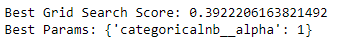

In [34]:
model = pickle.load(open('../models/CategoricalNB_10_classes_SMOTE.sav', 'rb'))

print(f'Train Accuracy: {model.score(X_train, y_train)}')
print(f'Holdout Accuracy: {model.score(X_hold,y_hold)}')
print(f"Train F1 score: {f1_score(y_train, model.predict(X_train), average = 'weighted')}")
print(f"Holdout F1 score: {f1_score(y_hold, model.predict(X_hold), average = 'weighted')}")

Train Accuracy: 0.56932
Holdout Accuracy: 0.41132
Train F1 score: 0.5657046542702858
Holdout F1 score: 0.4028570032476372


In [36]:
print(f'Trainset MAP@5 score: {mapk_score(model, X_train, y_train)}')
print(f'Testset MAP@5 score: {mapk_score(model, X_hold, y_hold)}')

Trainset MAP@5 score: 0.7219195555555555
Testset MAP@5 score: 0.5912913333333333


We are using SMOTEN here instead of SMOTE as it is designed for categorical features. We didn't use StandardScaling before SMOTE as our data although numeric, represent categories.  

Since using SMOTEN did not return to us significantly better results. We shall not use SMOTEN as it is computationally expensive. Also it is not feasible to SMOTEN all 100 classes as we will run of memory very fast.

#### Whole dataset

In [37]:
data_sub = data[:]

X = data_sub.drop(['date_time','cnt','hotel_cluster'], axis = 1)
y = data_sub['hotel_cluster']
X_train, X_hold, y_train, y_hold = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                    stratify=y                                                
                                                   )

In [38]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import SMOTEN

pipe = make_pipeline(CategoricalEncoder(),                     
                     OrdinalEncoder(),                     
                     CategoricalNB())

params = {'categoricalnb__alpha': [1]}

gs = GridSearchCV(pipe,
                  param_grid= params,
                  cv = 5,
                  scoring = 'f1_weighted',
                  n_jobs = -1,
                  error_score='raise',
                 )

In [39]:
# model have been ran and saved.

# gs.fit(X_train,y_train)
# print(f'Best Grid Search Score: {gs.best_score_}')
# print(f'Best Params: {gs.best_params_}')
# model = gs.best_estimator_
# pickle.dump(model, open('../models/CategoricalNB_full_dataset_NoSMOTE.sav', 'wb'))

Best Grid Search Score: 0.19007261788554503
Best Params: {'categoricalnb__alpha': 1}


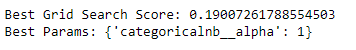

In [40]:
model = pickle.load(open('../models/CategoricalNB_full_dataset_NoSMOTE.sav', 'rb'))

print(f'Train Score: {model.score(X_train, y_train)}')
print(f'Holdout Score: {model.score(X_hold,y_hold)}')
print(f"Train F1 score: {f1_score(y_train, model.predict(X_train), average = 'weighted')}")
print(f"Holdout F1 score: {f1_score(y_hold, model.predict(X_hold), average = 'weighted')}")

Train Score: 0.32923205713882
Holdout Score: 0.21928245980265912
Train F1 score: 0.3122700377621458
Holdout F1 score: 0.19695961024049144


In [42]:
print(f'Trainset MAP@5 score: {mapk_score(model, X_train, y_train)}')
print(f'Testset MAP@5 score: {mapk_score(model, X_hold, y_hold)}')

Trainset MAP@5 score: 0.4626783940356281
Testset MAP@5 score: 0.34403696120277877


#### Predict for Kaggle (Only Run if Wanted to save file for Kaggle Submission)

In [43]:
# kaggle_ce = kaggle.drop(['id','date_time'], axis = 1)
# kaggle_pred = pd.DataFrame(model.predict_proba(kaggle_ce), columns = model.classes_)
# submit = convert_pdformat_to_kaggleformat(kaggle_pred, kaggle)
# submit.to_csv('../datasets/submission_Naive_Bayes.csv', index = False)

#### Evaluation

Here we are using the Categorical Naive Bayes model from sklearn. We are using this model instead of other Naive Bayes model as it is the most suitable for classification with discrete features that are categoircally distributed i.e. it makes no assumption about linearly or rank within the features. (MultinomialNB is more suitable for text but in MultinominalNB, the denominator will the total number of words in that particular class, while in CategoricalNB it is a total number of data points with a particular class. https://towardsdatascience.com/how-i-was-using-naive-bayes-incorrectly-till-now-part-1-4ed2a7e2212b).  

Even though we are using ordinalencoding in the pipeline, we are not ranking the categories as CategoricalNB does not assume order in the categories. This is only a hack to rename all the categories as integars as our categories are in strings for easier input into CategoricalNB. This can be found under description of X in CategoricalNB documentation. (https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html)

We faced the challenge because we are handling classification for 100 classes, we needed our features to have significance variances within them. However this brings about another problem, as our features are all nominal categorical, to have larger variance within the features, the features need to have many categories and we end up having a high cardinality problem. High cardinalty gave us an issue where our model breaks when there is a mismatch in the categories that exist between the trainset and testset (i.e. when a category is in the testset but not in the trainset). We seek to solve this by implementing a custom transformer which group all our categories which exist in less than 10% of the data into a group named 'others' and also mapping all the categories that were in the testset but not in the trainset to be under this category, 'others'. This solved our problem of high cardinality.

With alpha (Laplace smoothing) set at 1, we achieve a train score of 0.329 and holdout score of 0.219 and a mapK score of 0.344.

This model got a Kaggle score of 0.29406.

#### Possible Further Improvement: 

We can try balancing the different classes more by using a undersampling for some of the classes and undersampling for some of the classes within memory allowance.

We can also explore using partial_fit in CategoricalNB to manage the memory usage. This will require the use of a custom pipeline.

### d. Random Forrest Classifier Model

#### Smaller Dataset (10 categories)

In [44]:
#subset if needed

most_popular_hotel_clusters = list(data['hotel_cluster'].value_counts()[0:10].index)
data_sub = data[data['hotel_cluster'].map(lambda x: x in most_popular_hotel_clusters)]
data_sub = data_sub[:100000]

X = data_sub.drop(['date_time','cnt','hotel_cluster'], axis = 1)
y = data_sub['hotel_cluster']
X_train, X_hold, y_train, y_hold = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                    stratify=y                                                
                                                   )

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder

pipe = make_pipeline(CategoricalEncoder(),
                     OneHotEncoder(),
                     RandomForestClassifier(n_estimators= 100))

params = {'randomforestclassifier__max_depth': [10, 15]}

gs = GridSearchCV(pipe,
                  param_grid= params,
                  cv = 5,
                  scoring = 'f1_weighted',
                  n_jobs = -1,
                  error_score='raise'
                  )

In [46]:
# model have been ran and saved.

# gs.fit(X_train,y_train)
# print(f'Best Grid Search Score: {gs.best_score_}')
# print(f'Best Params: {gs.best_params_}')
# model = gs.best_estimator_

# pickle.dump(model, open('../models/RandomForest_10_classes_NoSMOTE.sav', 'wb'))

Best Grid Search Score: 0.09626284576560966
Best Params: {'randomforestclassifier__max_depth': 15}


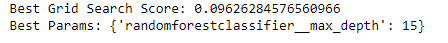

In [47]:
model = pickle.load(open('../models/RandomForest_10_classes_NoSMOTE.sav', 'rb'))

print(f'Train Accuracy: {model.score(X_train, y_train)}')
print(f'Holdout Accuracy: {model.score(X_hold,y_hold)}')
print(f"Train F1 score: {f1_score(y_train, model.predict(X_train), average = 'weighted')}")
print(f"Holdout F1 score: {f1_score(y_hold, model.predict(X_hold), average = 'weighted')}")

Train Accuracy: 0.20170666666666667
Holdout Accuracy: 0.19824
Train F1 score: 0.09878405753312088
Holdout F1 score: 0.09276463148389051


In [49]:
print(f'Trainset MAP@5 score: {mapk_score(model, X_train, y_train)}')
print(f'Testset MAP@5 score: {mapk_score(model, X_hold, y_hold)}')

Trainset MAP@5 score: 0.39066533333333336
Testset MAP@5 score: 0.3789246666666667


#### All classes with 200,000 data

In [50]:
#subset if needed

most_popular_hotel_clusters = list(data['hotel_cluster'].value_counts()[:].index)
data_sub = data[data['hotel_cluster'].map(lambda x: x in most_popular_hotel_clusters)]
data_sub = data_sub[:200_000]

X = data_sub.drop(['date_time','cnt','hotel_cluster'], axis = 1)
y = data_sub['hotel_cluster']
X_train, X_hold, y_train, y_hold = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                    stratify=y                                                
                                                   )

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder

pipe = make_pipeline(CategoricalEncoder(),
                     OneHotEncoder(),
                     RandomForestClassifier(n_estimators= 100))

params = {'randomforestclassifier__max_depth': [10, 15]}

gs = GridSearchCV(pipe,
                  param_grid= params,
                  cv = 5,
                  scoring = 'f1_weighted',
                  n_jobs = -1,
                  error_score='raise'
                  )

In [52]:
# model have been ran and saved.

# gs.fit(X_train,y_train)
# print(f'Best Grid Search Score: {gs.best_score_}')
# print(f'Best Params: {gs.best_params_}')
# model = gs.best_estimator_

# pickle.dump(model, open('../models/RandomForest_all_class_200kRows_NoSMOTE.sav', 'wb'))

Best Grid Search Score: 0.037398635959869996
Best Params: {'randomforestclassifier__max_depth': 15}


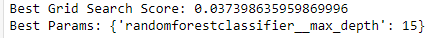

In [53]:
model = pickle.load(open('../models/RandomForest_all_class_200kRows_NoSMOTE.sav', 'rb'))

print(f'Train Accuracy: {model.score(X_train, y_train)}')
print(f'Holdout Accuracy: {model.score(X_hold,y_hold)}')
print(f"Train F1 score: {f1_score(y_train, model.predict(X_train), average = 'weighted')}")
print(f"Holdout F1 score: {f1_score(y_hold, model.predict(X_hold), average = 'weighted')}")

Train Accuracy: 0.08028
Holdout Accuracy: 0.06854
Train F1 score: 0.05278422354316209
Holdout F1 score: 0.03158347464341087


In [55]:
print(f'Trainset MAP@5 score: {mapk_score(model, X_train, y_train)}')
print(f'Testset MAP@5 score: {mapk_score(model, X_hold, y_hold)}')

Trainset MAP@5 score: 0.16237422222222223
Testset MAP@5 score: 0.1310623333333333


#### Predict for Kaggle (Only Run if Wanted to save file for Kaggle Submission)

In [56]:
# kaggle_ce = kaggle.drop(['id','date_time'], axis = 1)
# kaggle_pred = pd.DataFrame(model.predict_proba(kaggle_ce), columns = model.classes_)
# submit = convert_pdformat_to_kaggleformat(kaggle_pred, kaggle)
# submit.to_csv('../datasets/submission_Random_Forest.csv', index = False)

#### Evaluation

This model take a long time to run even with a small dataset. For 10 categories and 100,000 data, the MAP@5 score is 0.372 on the testset.

We tried running the full dataset and it didn't complete running in 12 hrs and we stop the model and we had to downsize our data to 200,000 with 100 classes. The trainset mapK score is 0.1623 and the testset mapK score is 0.1311 and the Kaggle score is 0.11743. 

At this stage, as on the smaller dataset it is not performing as well as CategoricalNB, we didn't pursue this model further. Given more resources, we can try again.

Random Forest Classifier also didn't work too well as we had to do OneHotEncoding to the features to avoid RandomForestClassifier from treating them like continuous features. However due to the high cardinality of our features, OneHotEncoding transform the original 14 features that we have to over 25,000 features which bogged the model and made the model needed a certain degree of depth to be effective. Notice that the trainset and holdset scores are close, showing no sign of overfit even though we already had a tree depth of 15. We probably had to relax the tree depth to deeper for better results. However that come at a computational trade off which we showed that is very expensive as we didn't even managed to run the model with the full dataset.

### e. K Nearest Neighbor

In [57]:
#subset
most_popular_hotel_clusters = list(data['hotel_cluster'].value_counts()[0:10].index)
data_sub = data[data['hotel_cluster'].map(lambda x: x in most_popular_hotel_clusters)]
data_sub = data_sub[:100_000]

X = data_sub.drop(['date_time','cnt','hotel_cluster'], axis = 1)
y = data_sub['hotel_cluster']
X_train, X_hold, y_train, y_hold = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                    stratify=y                                                
                                                   )

In [58]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTEN
from imblearn.pipeline import make_pipeline as imb_make_pipeline

pipe = imb_make_pipeline(SMOTEN(),
                         KNeighborsClassifier()
                        )
                 
params = {'kneighborsclassifier__n_neighbors': [9],
         }

gs = GridSearchCV(pipe,
                  param_grid= params,
                  cv = 5,
                  scoring = 'f1_weighted',
                  n_jobs = -1
                 )

In [59]:
# model have been ran and saved.

# gs.fit(X_train,y_train)
# print(f'Best Grid Search Score: {gs.best_score_}')
# print(f'Best Params: {gs.best_params_}')
# model = gs.best_estimator_

# pickle.dump(model, open('../models/KNN_10_classes_SMOTEN.sav', 'wb'))

Best Grid Search Score: 0.15554081331422745
Best Params: {'kneighborsclassifier__n_neighbors': 9}


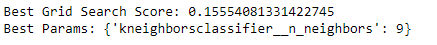

In [60]:
model = pickle.load(open('../models/KNN_10_classes_SMOTEN.sav', 'rb'))

print(f'Train Accuracy: {model.score(X_train, y_train)}')
print(f'Holdout Accuracy: {model.score(X_hold,y_hold)}')
print(f"Train F1 score: {f1_score(y_train, model.predict(X_train), average = 'weighted')}")
print(f"Holdout F1 score: {f1_score(y_hold, model.predict(X_hold), average = 'weighted')}")

Train Accuracy: 0.3310133333333333
Holdout Accuracy: 0.1602
Train F1 score: 0.3321194050917177
Holdout F1 score: 0.16196224785119456


In [62]:
print(f'Trainset MAP@5 score: {mapk_score(model, X_train, y_train)}')
print(f'Testset MAP@5 score: {mapk_score(model, X_hold, y_hold)}')

Trainset MAP@5 score: 0.5553855555555556
Testset MAP@5 score: 0.30893600000000004


#### Evaluation

KNearestNeighbour only achieve a mapK score of 0.3213 on the testset for a dataset with 10 classes and 100,000 datas, making it the lowest score of all. As per our expectation, as KNearestNeighbour utilise distance in its algorithm, as our features are all non linear nominal categorical features. This model is not working well. As such, we will not pursue this model more.

## 7. TensorFlow Recommendation System

#### Please refer to 'Part 3 - Appendix - TensorFlow Recommendation System.ipynb'

Here we decided to build a recommendation system and use the recommendation system to make the predictions. The title of this kaggle competition is Expedia recommendation system, and although the problem statement can be approached by using Supervised ML models. We wanted to try out recommendation system and we are also interested in deep learning models. When we know that tensorflow came out with a new library, tensorflow recommendation system (TFRS), in end 2020 , we decided to try out this new library.  

The code for this model is in 'Part 3 - Appendix - TensorFlow Recommendation System.ipynb'

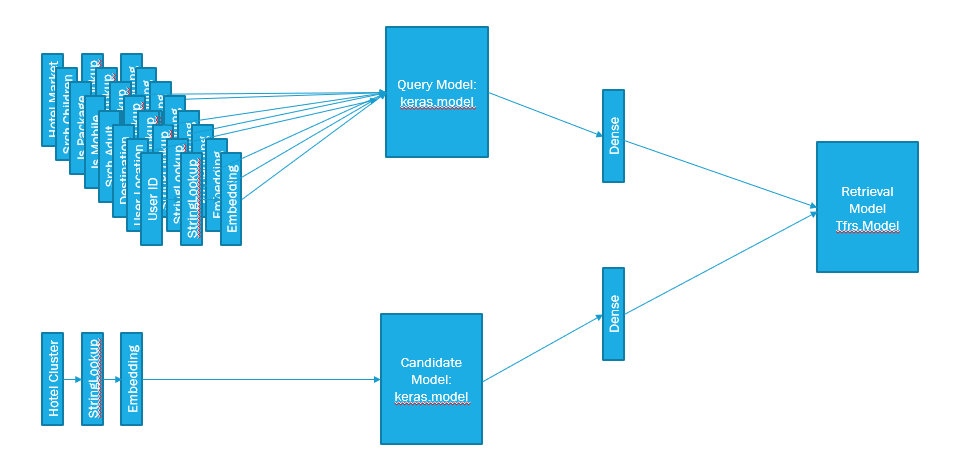

#### Evaluation

Our advanced TFRS model achieve a mapK score of 0.5695 on a subset of 10 classes and 100,000 datas. Making it the 2nd best performing model that we have. The training time is one of the fastest. Also there is more room for tuning and improvement on this model.

We proceeded to fit our model with the full dataset and the model achieved a trainset score of 0.8071 and a testset score of 0.3050. This obviously show overfitting which we can continue to finetune more. We like this model given the fact that despite the fact that we haven't improve on it much but it already achieved a score which put it in 2nd place of all our models and the score is not far away from our top model.

We also like that the model can handle new categories with ease which is a challenge for all our other ML models. Furthermore we can train this model by batches which will sort the issue of out of memory when training with huge datasets. This also means that we do not have to retrain the model when we have need data and we can continuiously improving the model when we have new data. In addition, the model is one of the models trained the fastest.

This model also have the flexibility to be reconfigured for different requirement. For example as mentioned earlier, our model is configured to recommend hotel cluster based on the user past preferences and searched destination. We can also reconfigure the model to recommend destinations and hotel cluster based on user past preferences by putting destination under the Candidate Model and using the destination dataset to find similarities between destinations.

This model obtain a Kaggle Score of 0.2194.

#### Possible Further improvement

1. Finetune the model to address overfitting using early stopping or regularization
2. Build a multitask TFRS model which include a ranking task.

## 8. Conclusion and Recommendations

|                     | Small Dataset (10 classes, 100,000 data) |                               |                            |                          |                      |               |
|---------------------|------------------------------------------|-------------------------------|----------------------------|--------------------------|----------------------|---------------|
|                     | Baseline                                 | CategoricalNB (without SMOTE) | CategoricalNB (with SMOTE) | Random Forest Classifier | K Nearest Neighbours | Advanced TFRS |
| Trainset MAPK Score | 0.0725                                   | 0.7354                        | 0.7224                     | 0.3907                   | 0.5554               | 0.9676        |
| Holdset MAPK Score  | 0.0725                                   | 0.6036                        | 0.5913                     | 0.3789                   | 0.3213               | 0.5695        |

We tested various different models using a small dataset which we filter out 10 classes and 100,000 data points from the main dataset. Above are the results. As expected, since our features are nominal features with no linearity within the features, K-Nearest Neighbor is not working well. We also tried Logistic Regression briefly which we didn't put in this notebook and that didn't work well either. Random Forest Classifier also didn't work too well as we had to do OneHotEncoding to the features to avoid RandomForestClassifier from treating them like continuous features. However due to the high cardinality of our features, OneHotEncoding transform the original 14 features that we have to over 25,000 features which bogged the model and made the model needed a certain degree of depth to be effective. Notice that the trainset and holdset scores are close, showing no sign of overfit even though we already had a tree depth of 15. We probably had to relax the tree depth to deeper for better results. However that come at a computational trade off which we showed that is very expensive as we didn't even managed to run the model with the full dataset.

This left us with our 2 best model using the CategoricalNB and TensorFlow Recommendation System. We tried using CategoricalNB with SMOTEN which didn't return to us significantly better results. When we tried to run SMOTEN on 100 classes, our system ran out of memory. As such we decided to test out the full dataset using our CategoricalNB (without SMOTE) model and our Advanced TensorFlow Recommendation System Model. Their results are as below.

|                     | Baseline | CategoricalNB (without SMOTE) | Advanced TFRS |
|---------------------|----------|-------------------------------|---------------|
| Trainset MAPK Score | 0.0725   | 0.4630                        | 0.8071        |
| Holdset MAPK Score  | 0.0725   | 0.3440                        | 0.3050        |
| Kaggle Score        | 0.0700   | 0.2941                        | 0.2194        |

Our best model is still CategoricalNB with a kaggle score of 0.2941 while our TFRS model achieved a score of 0.2194. Please note that work remains to be done for both our models especially our TFRS model which is still overfitted.

Possible Further Improvement for the CategoricalNB Model:

- We can try balancing the different classes more by using an undersampling for some of the classes and undersampling for some of the classes within memory allowance.

- We can also explore using partial_fit in CategoricalNB to manage the memory usage. This will require the use of a custom pipeline.

Possible Further Improvement for the TensorFlow Recommendation System Model:
    
- Finetune the model to address overfitting using early stopping or regularization

- Build a multitask TFRS model which include a ranking task.

That saying, we like the potential of our TFRS model. Despite us not yet having prevented it from overfitting, it already achieve a score close to our best model, the CategoricalNB model. Also there is ways that we can improve the model compared to the CategoricalNB Model.

We also like that the model can handle new categories with ease which is a challenge for all our other ML models including the CategoricalNB where we had to write a preprocessing step to categorical all new categories as 'others. Furthermore we can train this model by batches which will sort the issue of out of memory when training with huge datasets. This also means that we do not have to retrain the model when we have need data and we can keep improving the model when we have new data. In addition, the model is one of the models trained the fastest.

This model also have the flexibility to be reconfigured for different requirement. For example as mentioned earlier, our model is configured to recommend hotel cluster based on the user past preferences and searched destination. We can also reconfigure the model to recommend destinations and hotel cluster based on user past preferences by putting destination under the Candidate Model and using the destination dataset to find similarities between destinations.

In conclusion, we are satifised with the performance of our top 2 models especially the TFRS model which achieved a kaggle score of 0.2194 and beat the baseline score of 0.07. At the same time, the models can be further improved to achieve better scores which match the top scores in Kaggle.

## 9. References and Data Sources

1) https://towardsdatascience.com/how-i-was-using-naive-bayes-incorrectly-till-now-part-1-4ed2a7e2212b

2) https://towardsdatascience.com/naive-bayes-classifier-how-to-successfully-use-it-in-python-ecf76a995069

3) https://www.tensorflow.org/recommenders

4) https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159

5) https://towardsdatascience.com/how-to-encode-categorical-data-d44dde313131

6) https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd

7) https://www.kaggle.com/c/expedia-hotel-recommendations/overview

8) https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
